<a href="https://colab.research.google.com/github/sarthakkaushik/Cdiscount-Image-Classification/blob/main/Modeling%20with-%20Tfrecord%20File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jan 16 03:07:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
import os 
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'
os.chdir(data_path)
print(os.getcwd())

/gdrive/MyDrive/UOH Assignment Dataset/cdiscount


In [4]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread 

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *
from tensorflow.python.data.experimental import AUTOTUNE
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../cdiscount"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

categories.csv
category_names.csv
CheckPoints
file.h5
helper.py
helper.py.1
helper.py.10
helper.py.2
helper.py.3
helper.py.4
helper.py.5
helper.py.6
helper.py.7
helper.py.8
helper.py.9
output_data
__pycache__
sample_submission.csv
Tensorboard
test.bson
train.bson
train_example.bson
train_images.csv
training_logs
train_offsets.csv
train_TFrecords.tfrecords
val_images.csv



In [5]:
#Reading Tfrecord file
import IPython.display as display

data_dir = "../cdiscount/"

train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")


raw_dataset = tf.data.TFRecordDataset(train_tfrecord_path)

print(raw_dataset)

for raw_record in raw_dataset.take(1):
  print(raw_record)

<TFRecordDatasetV2 shapes: (), types: tf.string>
tf.Tensor(b'\n\x817\n\x13\n\nproduct_id\x12\x05\x1a\x03\n\x01\x00\n\x10\n\x06height\x12\x06\x1a\x04\n\x02\xb4\x01\n\x9c6\n\x07img_raw\x12\x906\n\x8d6\n\x8a6\x08\x07\x12\x00B\x836\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xb4\x00\xb4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()

In [6]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)
  # print(example.features.feature['img_raw'].numpy())

features {
  feature {
    key: "category_id"
    value {
      int64_list {
        value: 1000010653
      }
    }
  }
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 180
      }
    }
  }
  feature {
    key: "img_raw"
    value {
      bytes_list {
        value: "\010\007\022\000B\2036\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\000\264\000\264\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\

#Understanding the Tfrecord Data

Type of image_features <class 'dict'>
Type of image_features-Img_raw <class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'string'>
Numpy_array- <class 'bytes'> b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xb4\x00\xb4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x8

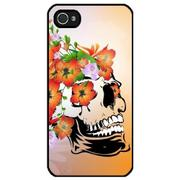

Category ID tf.Tensor(1000010653, shape=(), dtype=int64) 
Product ID- tf.Tensor(0, shape=(), dtype=int64)


In [16]:
#Reading Tfrecord file
import IPython.display as display

data_dir = "../cdiscount/"

train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")


raw_dataset = tf.data.TFRecordDataset(train_tfrecord_path)





#############################################################################################

from PIL import Image
def parse_tfr_element(element,img_shape=180):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'category_id':tf.io.FixedLenFeature([], tf.int64),      
      'product_id':tf.io.FixedLenFeature([], tf.int64),
      'img_raw' : tf.io.FixedLenFeature([], tf.string)
          }    
  return tf.io.parse_single_example(element, data)  

parsed_image_dataset = raw_dataset.map(parse_tfr_element)
parsed_image_dataset




########################################################################################

for image_features in parsed_image_dataset:
  print("Type of image_features",type(image_features))
  print("Type of image_features-Img_raw",type(image_features['img_raw']),image_features['img_raw'].dtype)
  image_raw = tf.io.parse_tensor(image_features['img_raw'],out_type=tf.string).numpy()

  # print("\nDtypee-",image_features.dtype)
  # print("\nDtypee-",image_raw.dtype())
  print("Numpy_array-",type(image_raw),image_raw)
  display.display(display.Image(data=image_raw))
  print("Category ID",image_features['category_id'],"\nProduct ID-",image_features['product_id'],
        # "\nHeight-",image_features['height'],
        # "\nWeidth-",image_features['width'],
        # "\ndepth-",image_features['depth']
        )
  break


#ROUGH WORK

In [21]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)  # 
    image = tf.image.resize(image,[180, 180])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        
        ####################################################3
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'category_id':tf.io.FixedLenFeature([], tf.int64),      
        'product_id':tf.io.FixedLenFeature([], tf.int64),
        'img_raw' : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    # image = decode_image(example['img_raw'])
    image = tf.io.parse_tensor(image_features['img_raw'],out_type=tf.string).numpy()
    display.display(display.Image(data=image))


    
    label = example['category_id']
    return image, label # returns a dataset of (image, label) pairs



def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


data_dir = "../cdiscount/"

train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")

Total_dataset = load_dataset(train_tfrecord_path)



##################################################
Total_Images=7069896
train_split = 0.6
validation_split = 0.2

num_train_images = int(Total_Images * train_split)
num_validation_images = int(Total_Images * validation_split)

train_dataset = Total_dataset.take(num_train_images)
validation_dataset = Total_dataset.skip(num_train_images).take(num_validation_images)
test_dataset = Total_dataset.skip(num_train_images + num_validation_images)


train_dataset=train_dataset.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset=validation_dataset.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)

##Testing-2

In [19]:
#Reading Tfrecord file
import IPython.display as display

data_dir = "../cdiscount/"

train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")


raw_dataset = tf.data.TFRecordDataset(train_tfrecord_path,num_parallel_reads=tf.data.AUTOTUNE)



DATASET_SIZE=1232287


################################################Train/Validation Split############################
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
print("Full_dataset-",full_dataset)
# full_dataset = full_dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size)
print('TFREC-',train_dataset)
test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

#################################

#############################################################################################

from PIL import Image
def parse_tfr_element(element,img_shape=180):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'category_id':tf.io.FixedLenFeature([], tf.int64),      
      'product_id':tf.io.FixedLenFeature([], tf.int64),
      'img_raw' : tf.io.FixedLenFeature([], tf.string)
          }    
  
  content = tf.io.parse_single_example(element, data) 
  
  height = content['height']
  width = content['width']
  depth = content['depth']
  label = content['category_id']
  product_id = content['product_id']
  img_raw = content['img_raw']
      
  
  #get our 'feature'-- our image -- and reshape it appropriately
  # image = tf.io.parse_tensor(img_raw,tf.uint8)
  # image =tf.io.decode_raw(img_raw,tf.uint8,fixed_length=97200)
  image = tf.io.parse_tensor(image_features['img_raw'],out_type=tf.string)

  display.display(display.Image(data=image))

  image = tf.cast(image, tf.float32)
  image = tf.reshape(image, [180, 180, 3])
  display.display(display.Image(data=image))


  
  return (image, label)



##########################################################################################


def get_dataset_small(filename):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

  #pass every single feature through our mapping function
  dataset = dataset.map(parse_tfr_element,num_parallel_calls=tf.data.AUTOTUNE)
    
  return dataset

################################################################################################

train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")
Total_dataset = get_dataset_small(train_tfrecord_path)
# train_data = get_dataset_small(train_dataset)


#Splitting the data 

#Total Images in train bson= 12371293

Total_Images=12371293
train_split = 0.6
validation_split = 0.2

num_train_images = int(Total_Images * train_split)
num_validation_images = int(Total_Images * validation_split)

train_dataset = Total_dataset.take(num_train_images)
validation_dataset = Total_dataset.skip(num_train_images).take(num_validation_images)
test_dataset = Total_dataset.skip(num_train_images + num_validation_images)


train_dataset=train_dataset.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset=validation_dataset.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)

# for image, label in validation_dataset.take(1):
#   print(image[0].shape)
#   print(image[1].shape)
#   print(image)
#   print(label)
#   # print(sample[0][1])
#   # print(sample[1][0])



# for sample in Total_dataset.take(1):
#   print(sample[0].shape)
#   print(sample[1].shape)
#   print(sample[0][1])
#   print(sample[1][0])


########################################################################################



################################################################################################

# train_tfrecord_path = os.path.join(data_dir, "train_TFrecords.tfrecords")
# train_data = get_dataset_small(train_tfrecord_path)
# print("Data before shuffle and batching- ", train_data)

# print("\nData before shuffle and batching-USING TAKE- ", train_data.take(1))

# # train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)
# # print("\nData AFTER shuffle and batching- ", train_data)

# for image, label in train_data.take(1):
#   print(image[0].shape)
#   print(image[1].shape)
#   print(image)
#   print(label)
#   # print(sample[0][1])
#   # print(sample[1][0])


########################################################################################


Full_dataset- <TFRecordDatasetV2 shapes: (), types: tf.string>
TFREC- <TakeDataset shapes: (), types: tf.string>


/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'tensorflow.python.framework.ops.Tensor'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

<IPython.core.display.Image object>

# New Section

To create a dataset out of the parse elements, we simply leverage the tf.data API. We create a TFRecordDataset by pointing it to the TFRecord file on our disk and then apply our previous parsing function to every extracted Example. This returns a dataset:

#Create modelling callbacks


In [11]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py

# Import helper functions we're going to use
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

dir_name = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard'
def create_tensorboard_callback(experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Setup checkpoint path
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet/Efficient_Tfrecord_test.ckpt' # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

--2022-01-15 05:22:17--  https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10510 (10K) [text/plain]
Saving to: ‘helper.py.10’

helper.py.10        100%[===================>]  10.26K  --.-KB/s    in 0.002s  

2022-01-15 05:22:18 (4.43 MB/s) - ‘helper.py.10’ saved [10510/10510]



In [12]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

mixed_precision.global_policy() # should output "mixed_float16"

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<Policy "mixed_float16">

##Build feature extraction model

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


num_classes = 5270
# Create base model
input_shape = (180, 180, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(num_classes)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

258088960/258076736 [==============================] - 2s 0us/step


In [14]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 pooling_layer (GlobalAverag  (None, 2560)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 5270)              13496470  
                                                                 
 softmax_float32 (Activation  (None, 5270)             0         
 )                                                               
                                                                 
Total params: 77,594,157
Trainable params: 13,496,470
Non-tra

In [15]:
#Checking layer dtype policies (are we using mixed precision?)

# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float16 <Policy "float16">
efficientnetb7 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Fit the model with callbacks
tf_history_1 = model.fit(train_dataset, 
                         epochs=3,
                         validation_data=validation_dataset,
                         callbacks=[checkpoint_callback,create_tensorboard_callback("efficientnetb7_Tfrecord_feature_extract")])

Saving TensorBoard log files to: /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard/efficientnetb7_Tfrecord_feature_extract/20220115-052435


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
    448/Unknown - 210s 393ms/step - loss: nan - accuracy: 0.0000e+00


  Image shape: (128, 180, 180, 3)
  Image dtype: <dtype: 'float32'>
  Target class from Food101 (tensor form): [1000003983 1000010653 1000010653 1000007590 1000010653 1000004085
 1000010653 1000010653 1000010667 1000010653 1000010653 1000010653
 1000010653 1000008933 1000016258 1000018705 1000010667 1000010722
 1000009591 1000010667 1000010653 1000004085 1000010635 1000010653
 1000008094 1000010667 1000010653 1000010667 1000010635 1000011423
 1000010661 1000004079 1000010653 1000010667 1000010653 1000010108
 1000010653 1000010661 1000010661 1000004079 1000014217 1000010793
 1000021533 1000010653 1000010136 1000004085 1000010108 1000002852
 1000010667 1000010667 1000010653 1000004079 1000010538 1000005956
 1000010653 1000010645 1000011566 1000010645 1000011566 1000010667
 1000010653 1000003796 1000010653 1000010667 1000010653 1000021535
 1000004184 1000010683 1000010653 1000005956 1000010653 1000005956
 1000010100 1000021535 1000010653 1000016093 1000016980 1000010667
 1000010653 10000

TypeError: ignored

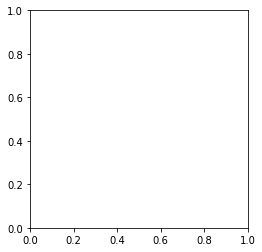

In [ ]:
train_one_sample=dataset.take(1)
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  
        """)
  # print(image)
  print(tf.reduce_min(image), tf.reduce_max(image))
  print(tf.squeeze())
  plt.imshow(image)
  # plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
  plt.axis(False);

We can explore the content of our dataset by taking a single data point:


In [ ]:
from PIL import Image
import io
import IPython.display as display
import matplotlib.pyplot as plt


# image_data = ... # byte values of the image
# image = Image.open(io.BytesIO(image_data))
# image.show()


for data in dataset(1):



    print(type(data))
    print("*"*100)
    print(data)
    print("*"*100)
    print(len(data[0]))
    print("*"*100)
    print(type(data[0]))
    print("*"*100)
    image_raw=data[0][50].numpy()
    # image_raw
    plt.imshow(image_raw)
    # display.display(display.Image(data=image_raw))
    # arr_ = np.squeeze(data) # you can give axis attribute if you wanna squeeze in specific dimension
    # image = Image.open(io.BytesIO(arr_))
    # image.show()

    # # plt.imshow(arr_.astype(np.uint8))
    # # plt.show()
    # print("*"*100)

    # print("Shape-",data.shape)
    # print("*"*100)
    # print(l)
    # print("*"*100)


TypeError: ignored

In [ ]:
#Importing packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,Dense, GlobalAveragePooling2D

num_classes = 5270

In [ ]:
#-----------------------TRAINING------------------------------------------------#


# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py

# Import helper functions we're going to use
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

dir_name = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard'
def create_tensorboard_callback(experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Setup checkpoint path
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/EfficientNet/Efficient_Tfrecord_test.ckpt' # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)




num_classes = 5270

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (180, 180, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(num_classes)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

--2022-01-13 19:12:41--  https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10510 (10K) [text/plain]
Saving to: ‘helper.py.7’

helper.py.7         100%[===================>]  10.26K  --.-KB/s    in 0.002s  

2022-01-13 19:12:42 (4.44 MB/s) - ‘helper.py.7’ saved [10510/10510]

258088960/258076736 [==============================] - 1s 0us/step


In [ ]:
# Fit the model with callbacks
history = model.fit(dataset, 
                    epochs=3,
                    validation_split=0.3,
                    # validation_steps=int(0.15 * len(dataset)),
                    # callbacks=[checkpoint_callback,create_tensorboard_callback("TranferLearning_EfficientNetB7_Tfrecord_Test")]
)

ValueError: ignored

FROM THE AUTHOR